# Abstract
Predictive coding offers a theoretical framework for understanding how the brain processes novel stimuli and continuously updates its internal representations of the world. This framework elucidates how the brain minimizes redundancy and encodes information efficiently. Empirical research has highlighted variations in the preference of ‘familiarity/novelty-encoding neurons’ across different cortical depths. Despite these insights, the specific localized encoding mechanisms crucial for explaining functional connectivity in decision-making tasks remain unknown.
We hypothesize that vasoactive intestinal peptide (VIP) interneurons in the deeper cortical layers play a significant role in modulating predictive coding. Specifically, we propose that these VIP interneurons suppress somatostatin (SST) inhibitory feedback, which targets novelty-encoding excitatory neurons in the shallower cortical layers. This suppression is expected to maintain the activity of excitatory neurons involved in encoding novel stimuli, thereby facilitating their contribution to the generation and updating of predictive models in response to new information.
To test this hypothesis, we will utilize the Allen Institute dataset, which includes 2-photon calcium imaging of neural activity in the visual cortex of mice engaged in behavioral tasks involving the detection of novel and familiar images. Our approach involves performing a time-series analysis to assess the impact of VIP activation on novelty-encoding excitatory populations in superficial layers. We will employ machine learning classifiers to analyze neuron activation from calcium fluorescence signals. The effects will be measured by evaluating delays in neuron activation and examining the dynamics of the VIP-SST disinhibitory circuit on excitatory populations.
We anticipate observing activation of VIP interneurons in the absence of activity from familiarity-encoding excitatory populations in deeper layers, followed by subsequent activation of novelty-encoding excitatory neurons in shallower layers. Such findings would suggest a feedback mechanism modulating predictive coding functions in cortical regions near the retina.

1. Function to average neuron dff values over time def avg_dff_vals(list_of_neurons, time_interval) -> ndarray containing avg dff values **with the timestep at each avg**
  a. Plot it
2. ML classifier to identify activations from dff data (over time). [0.002, 0.005, 0.2, 0.4, 0.8, 0.85, 0.83, 0.4, 0.09, 0.01] -> t=[6]
3. Find how to link imaging for VIP, SST, and excitatory cells in a single task session


Future
1. find novelty/familiarity-encoding excitatory neurons
2. plot PSTH of E/V/P avg activity per layer

# Setup

In [15]:
!pip install pip --upgrade --quiet
!pip install pandas --quiet
!pip install seaborn --quiet
!pip install numpy scipy matplotlib ipython jupyter pandas sympy nose --quiet
!pip install allensdk
!pip install brain_observatory_utilities --upgrade --quiet

In [16]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)
# this line may be needed if you run into Error in pandas query function
# Otherwise set the engine to python in queries made throught the book
# pd.DataFrame.query = lambda self, expr, **kwargs: self.query(expr, engine='python', **kwargs)

* Cross validation on excitatory and inhibitory
* PSTH for every neuron and average them over all the neurons to show excitatory are going up
* PCA to reduce / visualize dimensionality of the data - can filter down by layer, task (novel or familiar), or excitatory/SST/VIP

In [17]:
data_storage_directory = "./temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

/Users/michealmyers/anaconda3/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [60]:
# Session table filtering
session_table = session_table.query('behavior_type == "active_behavior"')

print(session_table['cre_line'].unique())
print("Number of sessions: %d" % len(session_table))
session_table.head()

['Sst-IRES-Cre' 'Vip-IRES-Cre' 'Slc17a7-IRES2-Cre']
Number of sessions: 495


,behavior_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,imaging_plane_group_count,project_code,session_type,session_number,image_set,behavior_type,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,num_depths_per_area,ophys_experiment_id,num_targeted_structures
ophys_session_id,,,,,,,,,,,,,,,,,,,,,,,,,
951410079,951520319,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,4,VisualBehaviorMultiscope,OPHYS_1_images_A,1,images_A,active_behavior,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,4,"[951980471, 951980473, 951980475, 951980479, 9...",2
954954402,953982960,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,210,4,VisualBehaviorMultiscope,OPHYS_3_images_A,3,images_A,active_behavior,Familiar,0,67,2,2019-09-24 09:01:31.582000+00:00,MESO.1,4,"[958527464, 958527471, 958527474, 958527479, 9...",2
955775716,956010809,"[1018028339, 1018028342, 1018028345]",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,212,2,VisualBehaviorMultiscope,OPHYS_3_images_A,3,images_A,active_behavior,Familiar,1,68,3,2019-09-26 09:22:21.772000+00:00,MESO.1,4,"[956941841, 956941844, 956941846]",2
957020350,957032492,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,213,4,VisualBehaviorMultiscope,OPHYS_4_images_B,4,images_B,active_behavior,Novel 1,0,0,4,2019-09-27 08:58:37.005000+00:00,MESO.1,4,"[957759562, 957759564, 957759566, 957759570, 9...",2
958105827,958234742,"[1018028342, 1018028345, 1018028351, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,216,3,VisualBehaviorMultiscope,OPHYS_3_images_A,3,images_A,active_behavior,Familiar,2,69,5,2019-09-30 08:58:29.173000+00:00,MESO.1,4,"[958741219, 958741222, 958741230, 958741232, 9...",2


In [71]:
for targeted_structure in ('VISp', 'VISl', 'VISal', 'VISam'):
    depth_vals = np.sort(experiment_table.query('targeted_structure == "%s"' % targeted_structure)['imaging_depth'].unique())
    print("%s Depth Range [%d, %d]" % (targeted_structure, depth_vals[0], depth_vals[-1]))

experiment_table.head()

VISp Depth Range [51, 383]
VISl Depth Range [65, 379]
VISal Depth Range [121, 308]
VISam Depth Range [101, 300]


,behavior_session_id,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,imaging_depth,targeted_structure,targeted_imaging_depth,imaging_plane_group,project_code,session_type,session_number,image_set,behavior_type,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951980471,951520319,951410079,1018028342,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,150,VISp,150,0,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,0
951980473,951520319,951410079,1018028345,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,225,VISp,225,0,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,1
951980475,951520319,951410079,1018028339,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,75,VISp,75,1,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,2
951980479,951520319,951410079,1018028354,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,150,VISl,150,2,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,3
951980481,951520319,951410079,1018028357,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,225,VISl,225,2,VisualBehaviorMultiscope,OPHYS_1_images_A,1,A,active_behavior,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,4


In [90]:
def get_experiments(ophys_experiment_ids):
  experiments = {}
  # for ophys_session_id in ophys_session_ids:
  #   ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
  for ophys_experiment_id in ophys_experiment_ids:
      experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)
  return experiments

def get_neural_data(experiments):
  neural_data = []
  for ophys_experiment_id in tqdm(experiments): #tqdm is a package that shows progress bars for items that are iterated over
      this_experiment = experiments.loc[ophys_experiment_id]
      this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

      # add some columns with metadata for the experiment
      metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
      ]
      for metadata_key in metadata_keys:
          this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

      # append the data for this experiment to a list
      neural_data.append(this_experiment_neural_data)

  # concatate the list of dataframes into a single dataframe
  neural_data = pd.concat(neural_data)
  return neural_data

def avg_dff_vals(neural_data: pd.DataFrame, time_interval: float):
    """
    Averages neuron dF/F values over specified time intervals.
    # Example usage:
    # Assuming 'neural_data' is your DataFrame and you want 100 timestamps
    num_timestamps = 100
    total_time = neural_data['timestamps'].max() - neural_data['timestamps'].min()
    time_interval = total_time / num_timestamps
    cell_ids_example = [1086613265]
    avg_dff = avg_dff_vals(neural_data[neural_data['cell_specimen_id'].isin(cell_ids_example)], time_interval)
    print(avg_dff)

    Args:
        neural_data: A pandas DataFrame containing neural data.
        time_interval: The time interval over which to average the dF/F values.

    Returns:
        A numpy ndarray containing the average dF/F values, with the timestep at each average.
    """
    # Create a new column for time bins based on the specified time interval
    neural_data_copy = neural_data.copy()
    neural_data_copy['time_bin'] = (neural_data['timestamps'] // time_interval).astype(int) * time_interval
    # Group by cell_specimen_id and time_bin, then calculate the mean dF/F for each group
    grouped_data = neural_data_copy.groupby(['cell_specimen_id', 'time_bin'])['dff'].mean().reset_index()
    # Pivot the table to have cell IDs as columns and time bins as index
    pivoted_data = grouped_data.pivot(index='time_bin', columns='cell_specimen_id', values='dff')
    pivoted_data['pop_avg'] = pivoted_data.mean(axis=1)
    # Rename index for clarity
    pivoted_data.index.name = 'timestep'

    return pivoted_data

def plot_avg_dff(avg_dff: pd.DataFrame, cell_ids: list):
  """ Plot the average dF/F values over time for the specified cells.
  Args:
      avg_dff: A pandas DataFrame containing the average dF/F values, with the timestep at each average.
      cell_ids: A list of cell IDs for which to plot the average dF/F values.
  """
  # Plot the average dF/F values over time for the specified cells
  for cell_id in cell_ids:
    if cell_id in avg_dff.columns:
        cell_data = avg_dff[[cell_id]]
        plt.plot(cell_data.index, cell_data[cell_id], label=f'Cell {cell_id}')

  plt.xlabel('Timestep')
  plt.ylabel('Average dF/F')
  plt.title('Average dF/F Over Time')
  plt.legend()

In [76]:
# ['Sst-IRES-Cre' 'Vip-IRES-Cre' 'Slc17a7-IRES2-Cre']
all_session_ids = session_table.index.tolist()
e_session_ids = session_table.query('cre_line == "Slc17a7-IRES2-Cre"').index.tolist()
sst_session_ids = session_table.query('cre_line == "Sst-IRES-Cre"').index.tolist()
vip_session_ids = session_table.query('cre_line == "Vip-IRES-Cre"').index.tolist()

print("# of sessions per neuron - Excitatory: %d, SST: %d, VIP: %d" % (len(e_session_ids), len(sst_session_ids), len(vip_session_ids)))

# of sessions per neuron - Excitatory: 253, SST: 111, VIP: 131


In [ ]:
all_experiments = experiment_table[experiment_table["ophys_session_id"].isin(all_session_ids)]
e_experiments = experiment_table[experiment_table["ophys_session_id"].isin(e_session_ids)]
sst_experiments = experiment_table[experiment_table["ophys_session_id"].isin(sst_session_ids)]
vip_experiments = experiment_table[experiment_table["ophys_session_id"].isin(vip_session_ids)]

for name, expr_table in (('Excitatory', e_experiments), ('SST', sst_experiments), ('VIP', vip_experiments)):
    print('%s neuron experiment info' % name)
    imaging_depths = np.sort(expr_table['imaging_depth'].unique())
    mice = np.sort(expr_table['mouse_id'].unique())
    sessions = expr_table['ophys_session_id'].unique()
    print("Number of experiments: %d, out of %d sessions" % (len(expr_table), len(sessions)))
    print("Imaging depths - length %d, Range: [%d, %d]" % (imaging_depths.size, imaging_depths[0], imaging_depths[-1]))
    print("Mice IDs - length %d" % (mice.size))
    print("\n")

print(vip_experiments.query('imaging_depth < 250').head())

In [93]:
experiments_data = get_experiments(all_experiments.index.tolist())

vip_shallow_exp = ()

neural_data = get_neural_data(experiments_data)

/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980479.nwb: 100%|██████████| 266M/266M [00:21<00:00, 12.4MMB/s]    
/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980481

KeyboardInterrupt: 

In [29]:
print(len(neural_data))
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))
print(neural_data.head())
print(neural_data['imaging_depth'].unique())
print(neural_data['cre_line'].unique())
print(neural_data['mouse_id'].unique())

1739376
there are 36 unique cells
cell ids are: [1086613265 1086613823 1086619526 1086614149 1086614351 1086614819
 1086615201 1086615620 1086615837 1086616206 1086619674 1086616398
 1086620813 1086621290 1086621434 1086621629 1086621968 1086622155
 1086622408 1086622595 1086622778 1086623189 1086623621 1086623929
 1086621122 1086619317 1086619511 1086619649 1086619787 1086619928
 1086620268 1086620350 1086621818 1086621907 1086620671 1086620900]
   timestamps       dff    events  filtered_events  cell_roi_id  \
0     9.26356  0.936573  0.000000         0.000000   1080743723   
1     9.35677  0.582486  0.000000         0.000000   1080743723   
2     9.44998  1.296005  0.556873         0.400762   1080743723   
3     9.54318  0.844898  0.000000         0.148502   1080743723   
4     9.63639  1.181188  0.467264         0.343829   1080743723   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086613265            951980471         951410079       

       timestamps       dff    events  filtered_events cell_roi_id  \
0         9.26356  0.936573  0.000000     0.000000e+00  1080743723   
1         9.35677  0.582486  0.000000     0.000000e+00  1080743723   
2         9.44998  1.296005  0.556873     4.007621e-01  1080743723   
3         9.54318  0.844898  0.000000     1.485021e-01  1080743723   
4         9.63639  1.181188  0.467264     3.438292e-01  1080743723   
...           ...       ...       ...              ...         ...   
48311  4513.43879  0.000000  0.000000    1.643599e-156  1080743723   
48312  4513.53202  0.000000  0.000000     0.000000e+00  1080743723   
48313  4513.62526  0.000000  0.000000     0.000000e+00  1080743723   
48314  4513.71849  0.185738  0.000000     0.000000e+00  1080743723   
48315  4513.81173  0.154714  0.000000     0.000000e+00  1080743723   

      cell_specimen_id  ophys_experiment_id  ophys_session_id  \
0           1086613265            951980471         951410079   
1           1086613265       

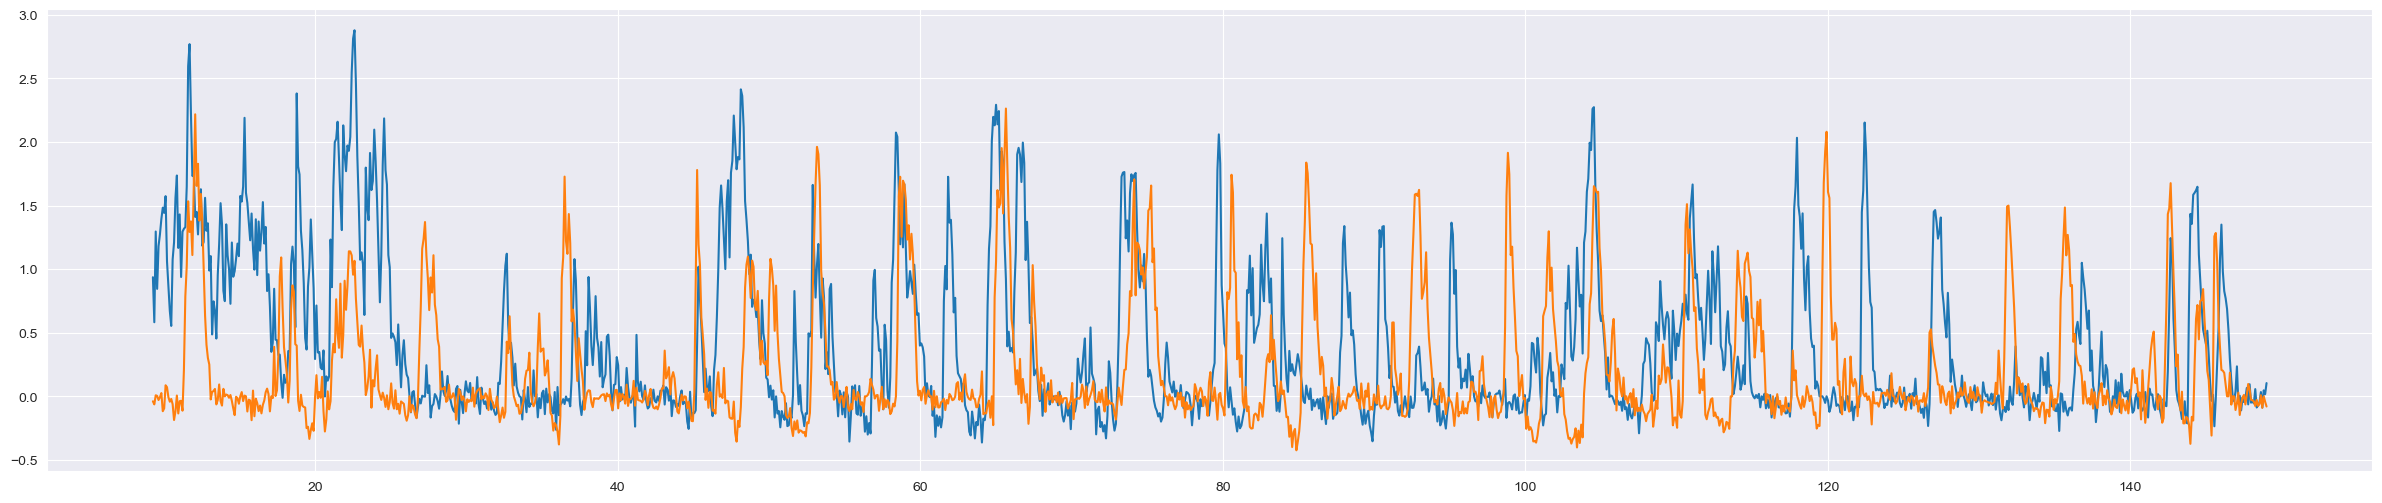

In [33]:
one_visp = visp_data.query('cell_specimen_id == 1086613265')
print(one_visp)
one_visp['timestamps'][0:500]
plt.figure(figsize=(30, 6))
plt.plot(one_visp['timestamps'][0:1500], one_visp['dff'][0:1500])
plt.plot(one_visp['timestamps'][0:1500], one_visp['dff'][1500:3000])

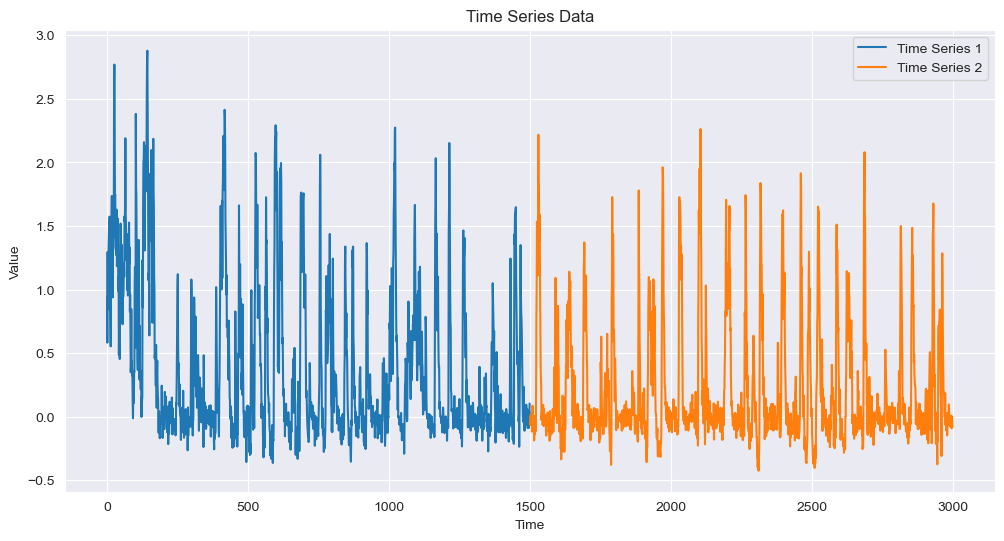

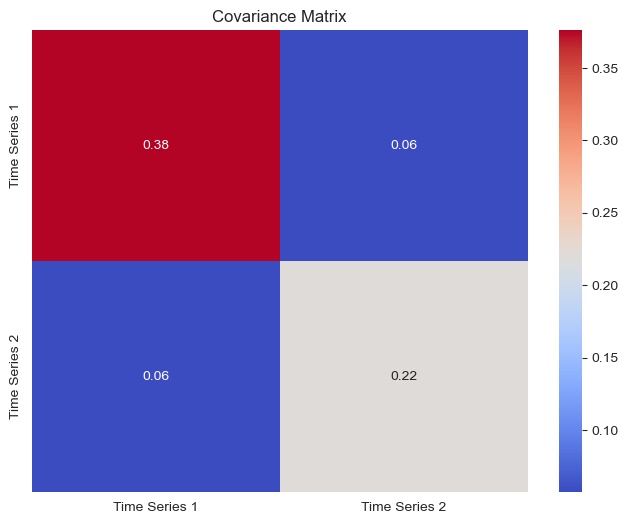

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import LedoitWolf

def generate_covariance_matrix(time_series_1, time_series_2):
    # Stack the time series data column-wise
    data = np.vstack((time_series_1, time_series_2)).T
    # Compute the Ledoit-Wolf covariance matrix
    cov_model = LedoitWolf().fit(data)
    cov_matrix = cov_model.covariance_
    return cov_matrix

# Generate sample time series data
np.random.seed(902034342)
time_series_length = 100
time_series_1 = one_visp['dff'][0:1500]
time_series_2 = one_visp['dff'][1500:3000]

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(time_series_1, label='Time Series 1')
plt.plot(time_series_2, label='Time Series 2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.legend()
plt.show()

covariance = generate_covariance_matrix(time_series_1, time_series_2)
# Visualize the covariance matrix
plt.figure(figsize=(8, 6))
sns.heatmap(covariance, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=['Time Series 1', 'Time Series 2'], yticklabels=['Time Series 1', 'Time Series 2'])
plt.title('Covariance Matrix')
plt.show()

Goal: Plot responses from excitatory, VIP, and SST during 1) familiar 2) novel